In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md
from lipyphilic.lib.assign_leaflets import AssignLeaflets
from lipyphilic.lib.assign_leaflets import AssignCurvedLeaflets
from lipyphilic.lib.area_per_lipid import AreaPerLipid
import MDAnalysis as mda


c:\Users\hainn\anaconda3\envs\CHEM101\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
pdb='/Users/hainn/tolu/git/CHEM101.6_S24/tolu_chem101_final_project/stripped_structure_frame1.pdb'
trajectory='/Users/hainn/tolu/git/CHEM101.6_S24/tolu_chem101_final_project/stripped_trajectory_001.xtc'
outdir='/Users/hainn/tolu/git/CHEM101.6_S24/tolu_chem101_final_project/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)



outdir: /Users/hainn/tolu/git/CHEM101.6_S24/tolu_chem101_final_project/output
pdb: /Users/hainn/tolu/git/CHEM101.6_S24/tolu_chem101_final_project/stripped_structure_frame1.pdb
trjaectory: /Users/hainn/tolu/git/CHEM101.6_S24/tolu_chem101_final_project/stripped_trajectory_001.xtc


In [3]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

c:\Users\hainn\anaconda3\envs\CHEM101\Lib\site-packages\mdtraj\formats\pdb\pdbfile.py:198: RuntimeWarning: divide by zero encountered in divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
c:\Users\hainn\anaconda3\envs\CHEM101\Lib\site-packages\mdtraj\formats\pdb\pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 68302

Number of residues: 494

Number of frames: 10000

Starting frame: 0

Last frame: 10000

sequence:  [MET1, ILE2, ARG3, GLU4, ILE5, SER6, ASN7, LEU8, GLN9, LYS10, ASP11, ILE12, ILE13, ASN14, ILE15, GLN16, ASP17, SER18, TYR19, SER20, ASN21, ASN22, ARG23, VAL24, MET25, ASP26, VAL27, GLY28, ARG29, ASN30, ASN31, ARG32, LYS33, ASN34, MET35, SER36, PHE37, ARG38, SER39, SER40, PRO41, GLU42, LYS43, SER44, LYS45, GLN46, GLU47, LEU48, ARG49, ARG50, SER51, PHE52, SER53, ALA54, GLN55, LYS56, ARG57, MET58, MET59, ILE60, PRO61, ALA62, ASN63, TYR64, PHE65, SER66, LEU67, GLU68, SER69, LEU70, PHE71, LEU72, LEU73, VAL74, GLY75, LEU76, THR77, ALA78, SER79, LEU80, LEU81, ILE82, LEU83, PRO84, LEU85, VAL86, LEU87, PRO88, PRO89, LEU90, PRO91, PRO92, PRO93, PRO94, PHE95, MET96, LEU97, LEU98, LEU99, VAL100, PRO101, ILE102, GLY103, ILE104, MET105, VAL106, LEU107, LEU108, VAL109, VAL110, LEU111, ALA112, PHE113, MET114, PRO115, SER116, SER117, HIS118, SER119, ASN120, ALA12

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  5

In [6]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'H', 'H', ..., 'NA', 'NA', 'NA'],
       ['C', 'C', 'H', ..., 'NA', 'NA', 'NA'],
       ['C', 'C', 'H', ..., 'NA', 'NA', 'NA'],
       ...,
       ['C', 'H', 'H', ..., 'NA', 'NA', 'NA'],
       ['C', 'H', 'H', ..., 'NA', 'NA', 'NA'],
       ['C', 'H', 'H', ..., 'NA', 'NA', 'NA']], dtype='<U2')

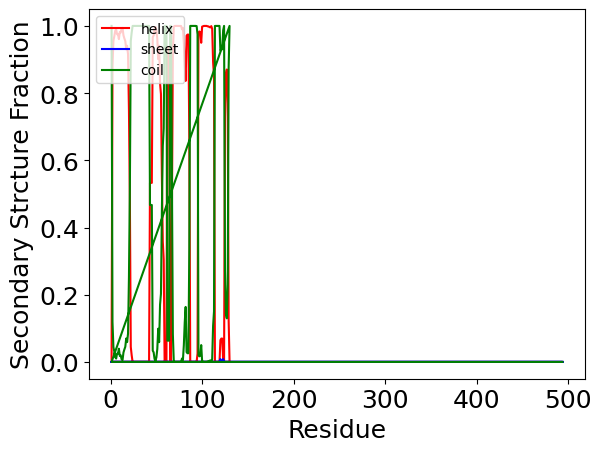

In [7]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspC = np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 

 dsspC[dsspC=='H']=0
 dsspC[dsspC=='E']=0
 dsspC[dsspC=='C']=1
 dsspC[dsspC=='NA']=0
 dsspC=dsspC.astype(int)
 TotalC=np.sum(dsspC,axis=1) 
 Cprop=np.sum(dsspC,axis=0).astype(float)/len(dsspC) 
 return Hprop, Eprop, Cprop


Hprop,Eprop,Cprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')
plt.plot(residue_num,Cprop,c='g',label='coil')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


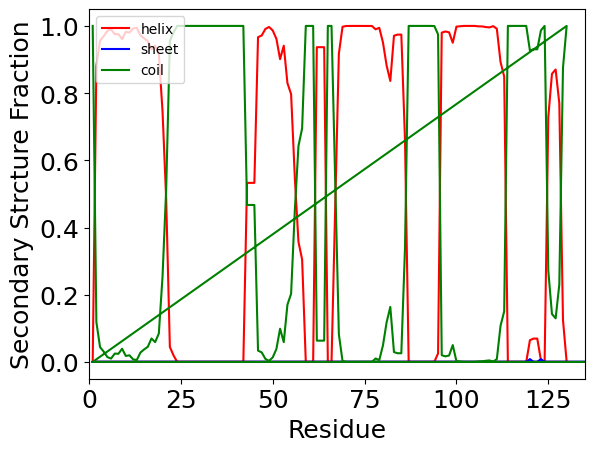

In [8]:
Hprop,Eprop,Cprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')
plt.plot(residue_num,Cprop,c='g',label='coil')
plt.legend(loc="upper left")

plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.xlim(0,135)
plt.tick_params(labelsize=18)

In [9]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [10]:
np.shape(phis[:,0])

(10000,)

In [11]:
np.shape(indices_phi)

(129, 4)

In [12]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [13]:
sequence

' [MET1, ILE2, ARG3, GLU4, ILE5, SER6, ASN7, LEU8, GLN9, LYS10, ASP11, ILE12, ILE13, ASN14, ILE15, GLN16, ASP17, SER18, TYR19, SER20, ASN21, ASN22, ARG23, VAL24, MET25, ASP26, VAL27, GLY28, ARG29, ASN30, ASN31, ARG32, LYS33, ASN34, MET35, SER36, PHE37, ARG38, SER39, SER40, PRO41, GLU42, LYS43, SER44, LYS45, GLN46, GLU47, LEU48, ARG49, ARG50, SER51, PHE52, SER53, ALA54, GLN55, LYS56, ARG57, MET58, MET59, ILE60, PRO61, ALA62, ASN63, TYR64, PHE65, SER66, LEU67, GLU68, SER69, LEU70, PHE71, LEU72, LEU73, VAL74, GLY75, LEU76, THR77, ALA78, SER79, LEU80, LEU81, ILE82, LEU83, PRO84, LEU85, VAL86, LEU87, PRO88, PRO89, LEU90, PRO91, PRO92, PRO93, PRO94, PHE95, MET96, LEU97, LEU98, LEU99, VAL100, PRO101, ILE102, GLY103, ILE104, MET105, VAL106, LEU107, LEU108, VAL109, VAL110, LEU111, ALA112, PHE113, MET114, PRO115, SER116, SER117, HIS118, SER119, ASN120, ALA121, ASN122, THR123, ASP124, VAL125, THR126, CYS127, ASN128, PHE129, MET130, POP1, POP2, POP3, POP4, POP5, POP6, POP7, POP8, POP9, POP10, POP1

In [14]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




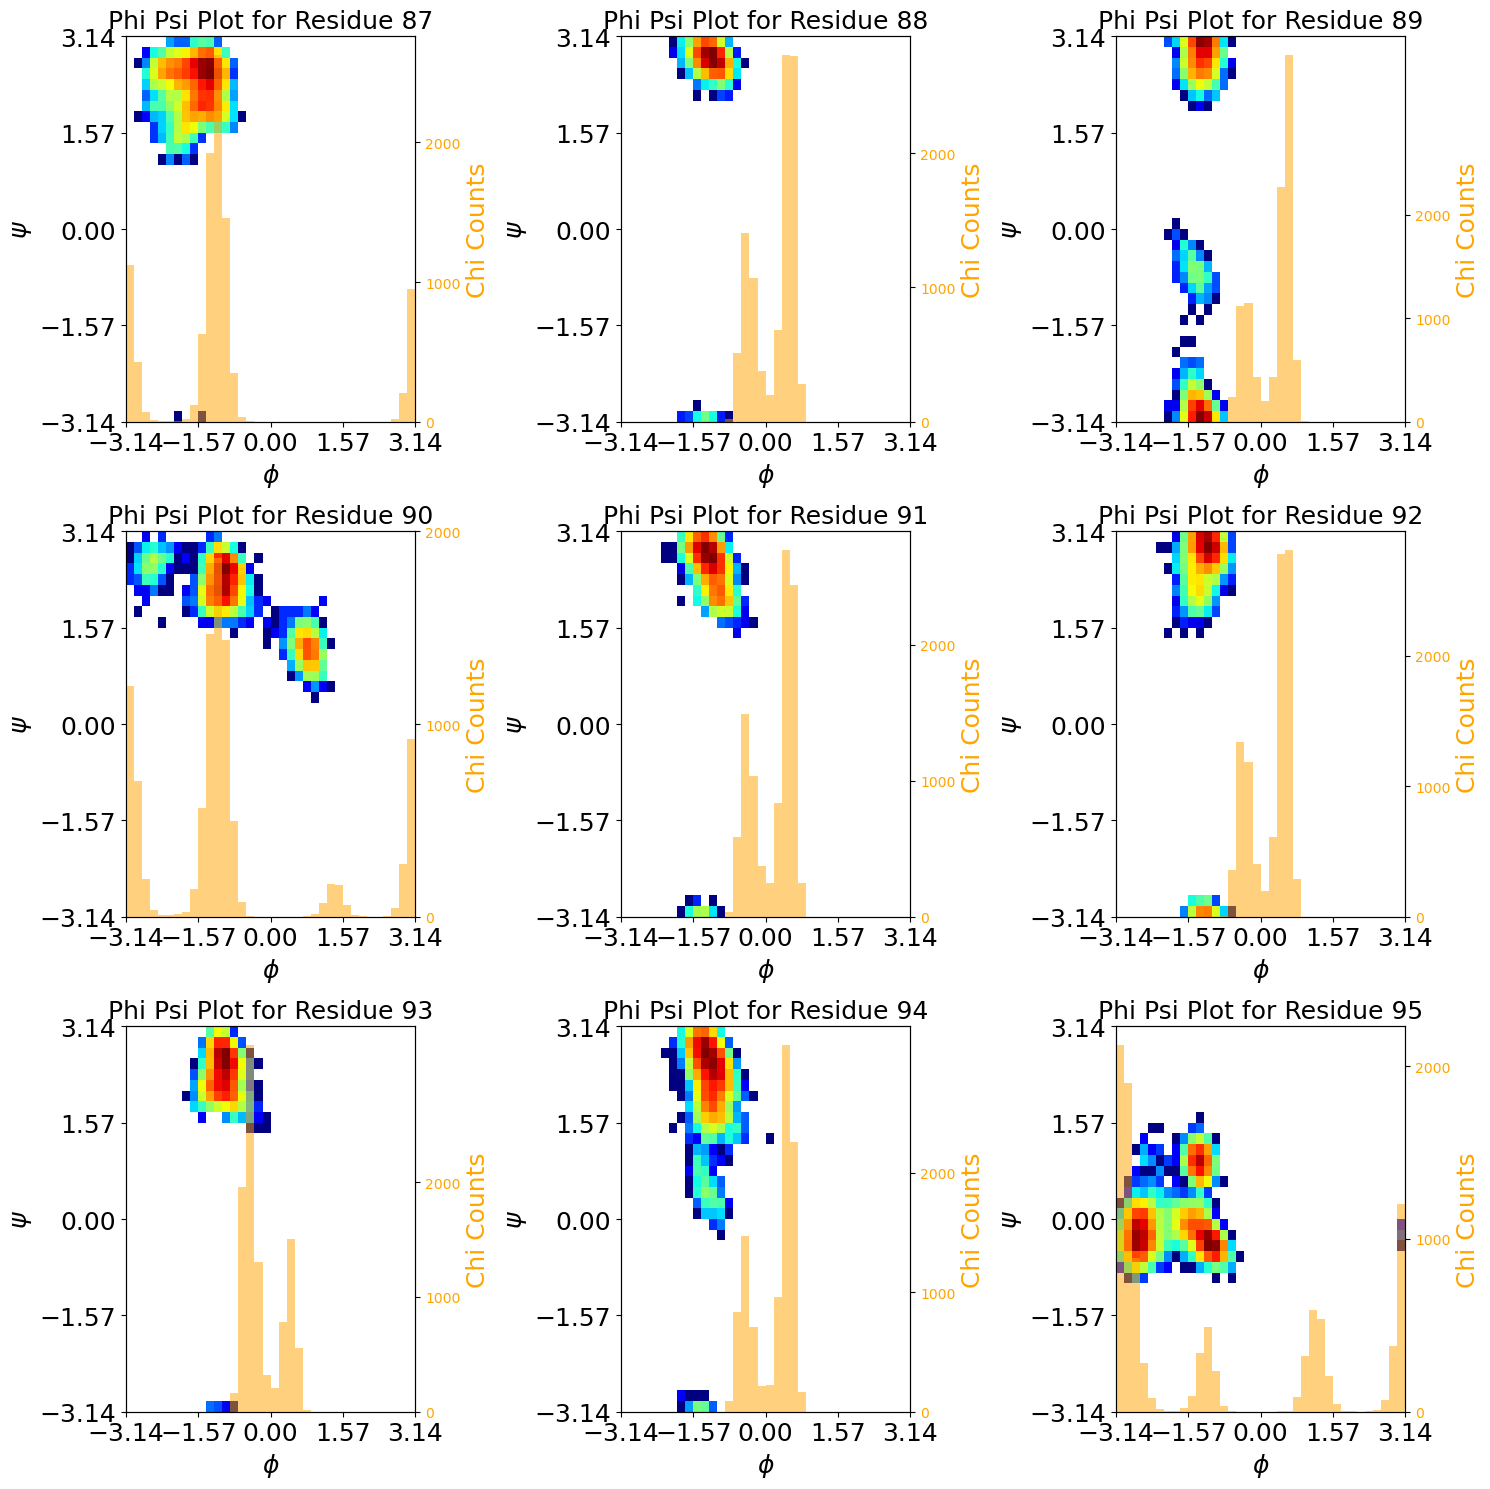

In [15]:

def plot_phipsi(res, ax=None):
    if ax is None:
        ax = plt.gca()

    # Phi Psi plot
    ax.hist2d(dihedral_dict['phi'][res], dihedral_dict['psi'][res], bins=36, range=[[-3.14, 3.14], [-3.14, 3.14]], norm=colors.LogNorm(), cmap='jet')
    ax.set_xlabel('$\phi$', size=18)
    ax.set_ylabel('$\psi$', size=18)
    ax.set_xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
    ax.set_yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
    ax.tick_params(labelsize=18)
    ax.set_title(f'Phi Psi Plot for Residue {res}', size=18)

    # Chi plot
    if res in dihedral_dict['chi1']:
        ax2 = ax.twinx()  # Create a second y-axis sharing the same x-axis
        ax2.hist(dihedral_dict['chi1'][res], bins=36, range=[-3.14, 3.14], alpha=0.5, color='orange')
        ax2.set_ylabel('Chi Counts', color='orange', size=18)
        ax2.tick_params(axis='y', labelcolor='orange')
        ax2.set_yticks([0, 1000, 2000])  # Adjust as needed

def plot_multiple_phipsi(*residues):
    num_plots = len(residues)
    num_cols = 3  # Number of columns for subplots
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    for i, residue in enumerate(residues):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        plot_phipsi(residue, ax=ax)

    plt.tight_layout()
    plt.show()

# Example usage
plot_multiple_phipsi(87, 88, 89, 90, 91, 92, 93, 94, 95)


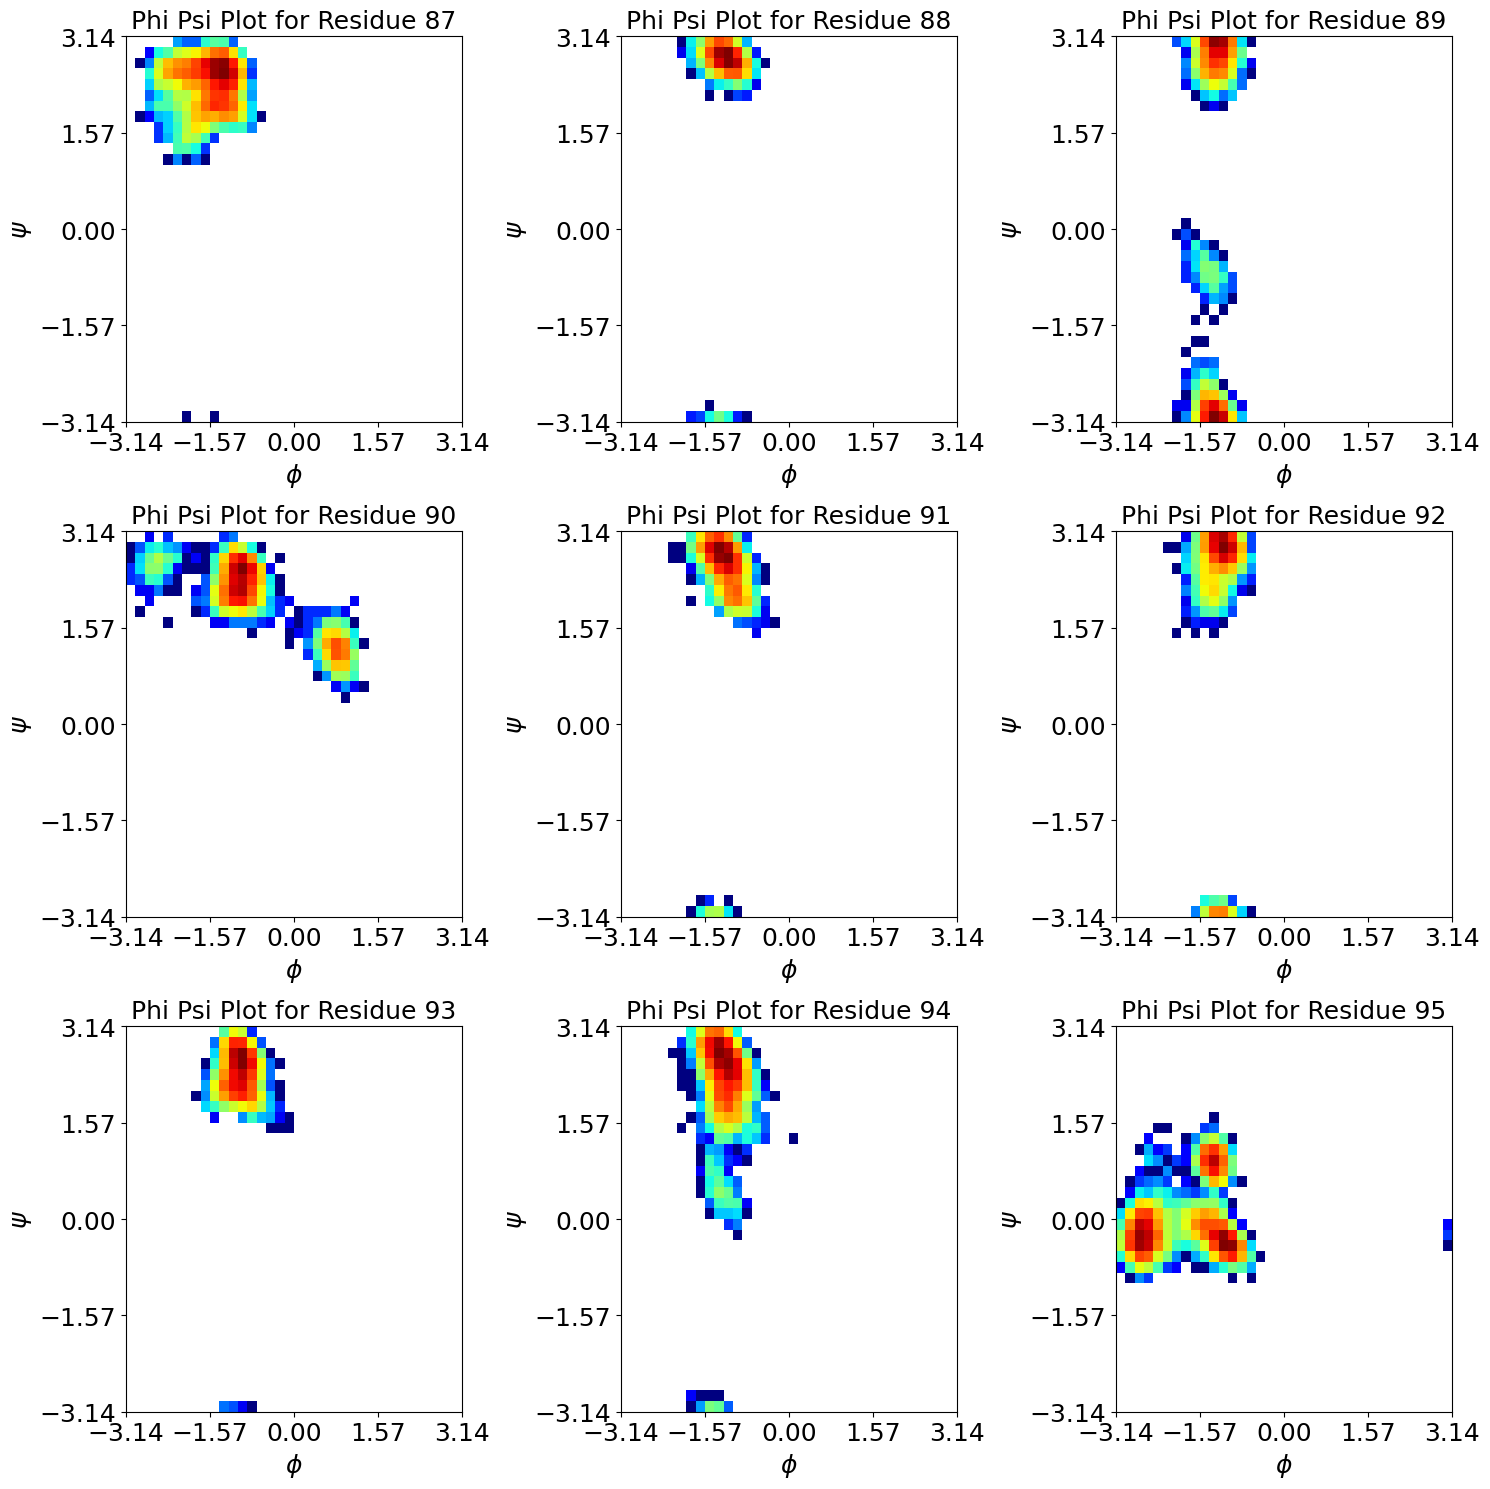

In [16]:

def plot_phipsi(res, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.hist2d(dihedral_dict['phi'][res], dihedral_dict['psi'][res], bins=36, range=[[-3.14, 3.14], [-3.14, 3.14]], norm=colors.LogNorm(), cmap='jet')
    ax.set_xlabel('$\phi$', size=18)
    ax.set_ylabel('$\psi$', size=18)
    ax.set_xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
    ax.set_yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
    ax.tick_params(labelsize=18)
    ax.set_title(f'Phi Psi Plot for Residue {res}', size=18)

def plot_multiple_phipsi(*residues):
    num_plots = len(residues)
    num_cols = 3  # Number of columns for subplots
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    for i, residue in enumerate(residues):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        plot_phipsi(residue, ax=ax)

    plt.tight_layout()
    plt.show()

# Example usage
plot_multiple_phipsi(87, 88, 89, 90, 91, 92, 93, 94, 95)


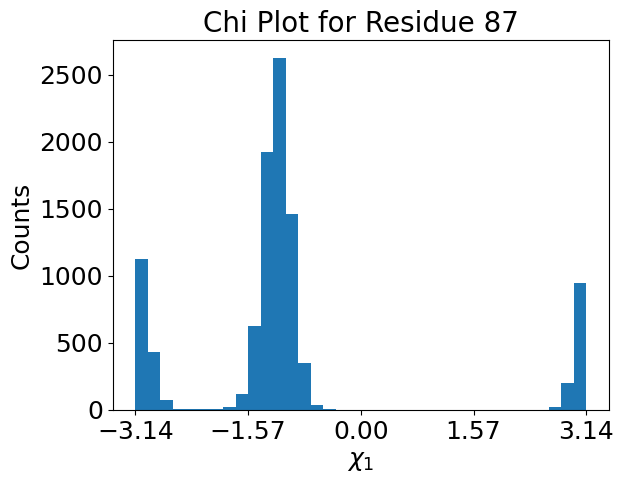

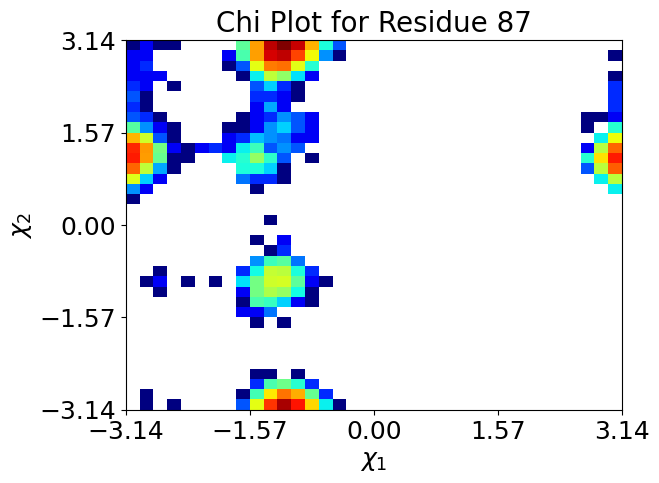

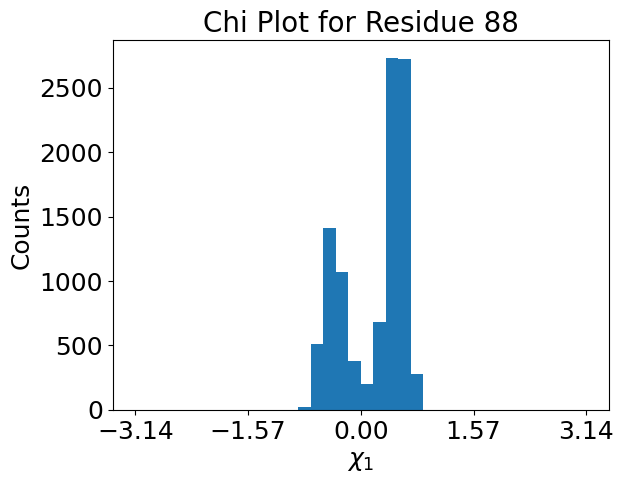

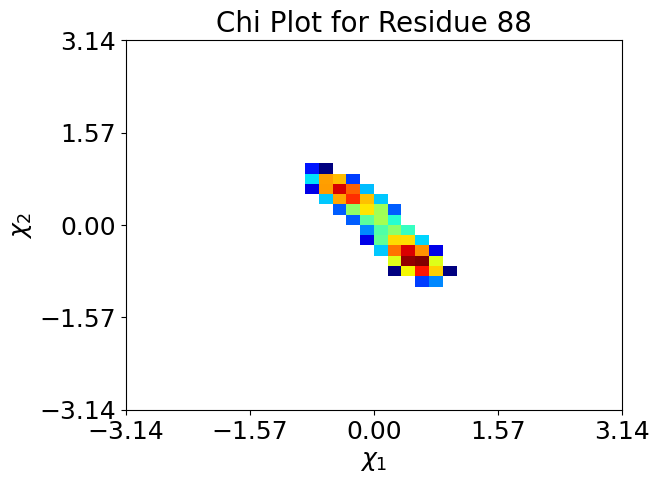

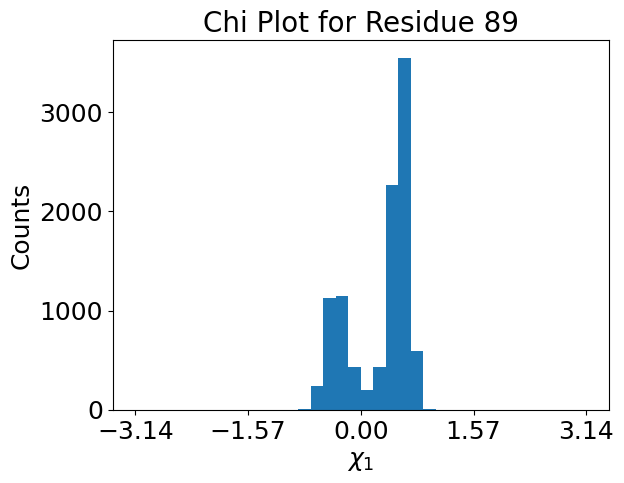

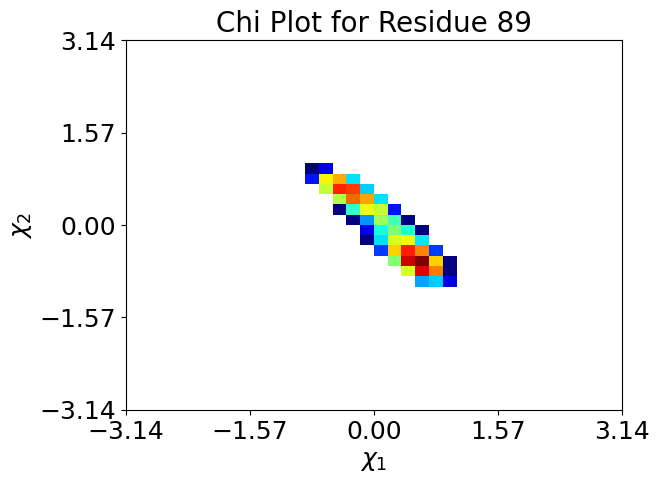

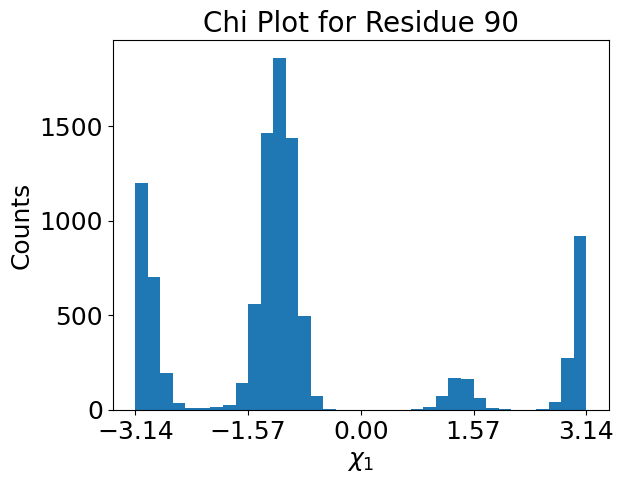

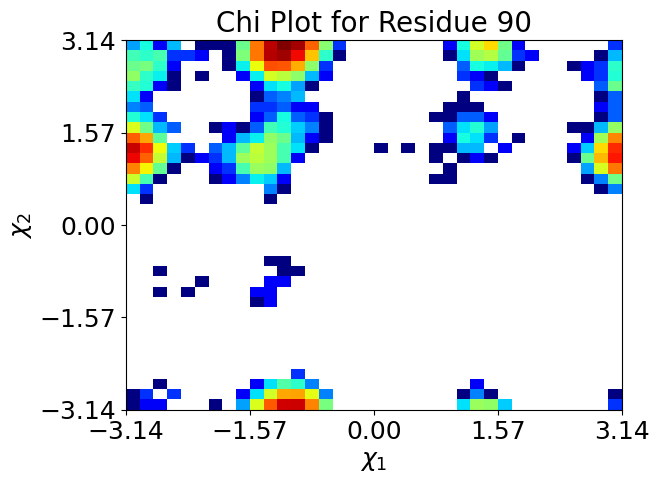

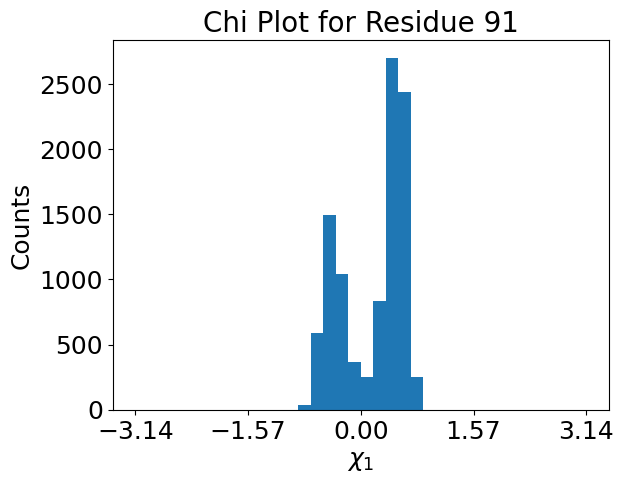

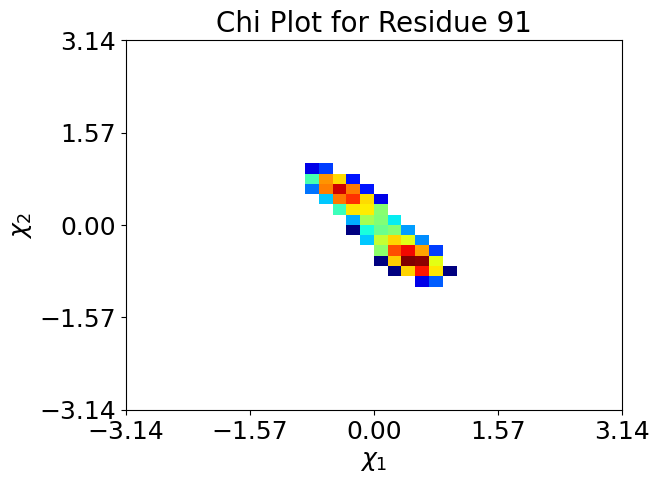

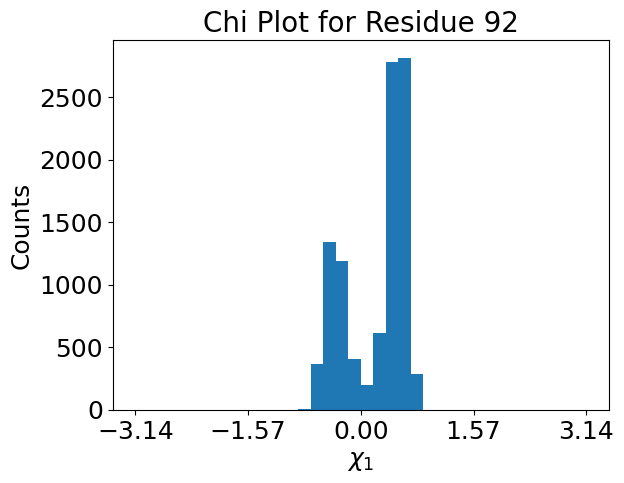

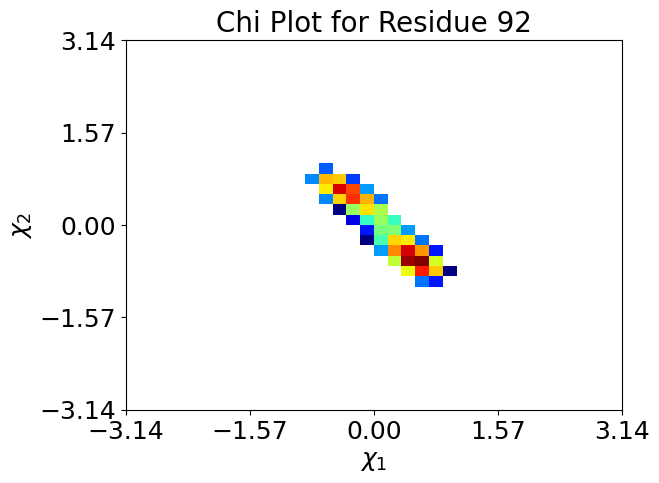

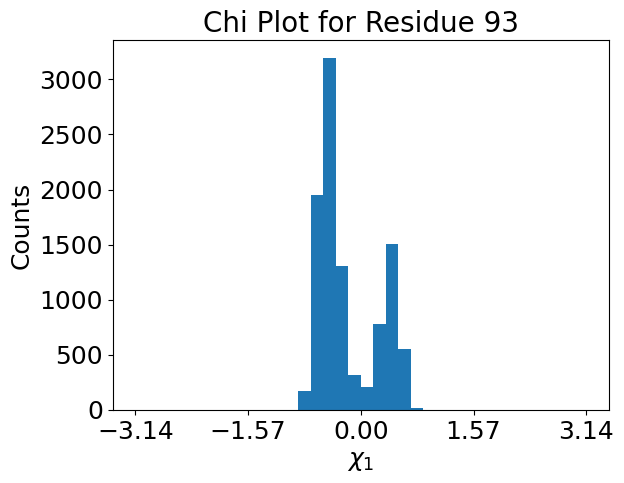

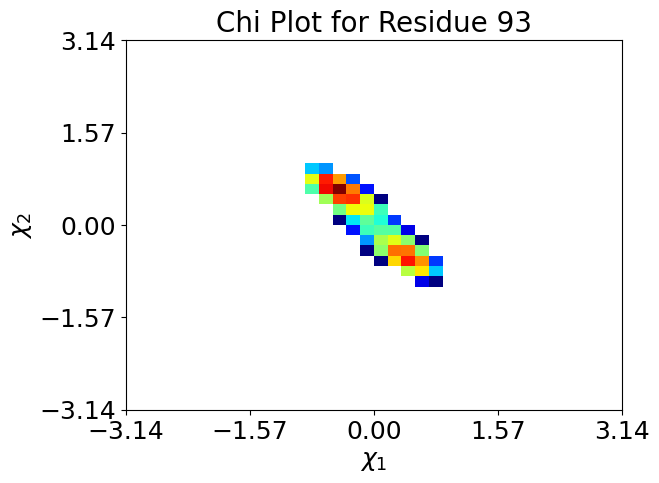

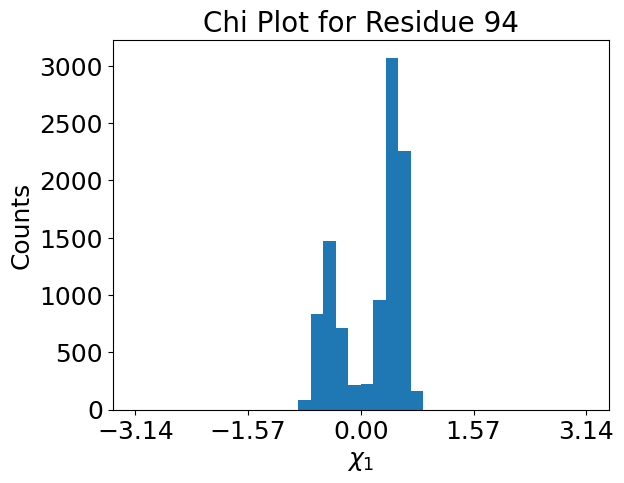

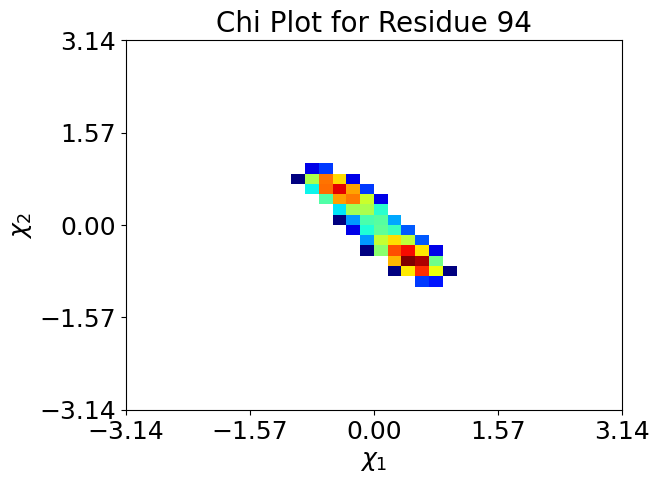

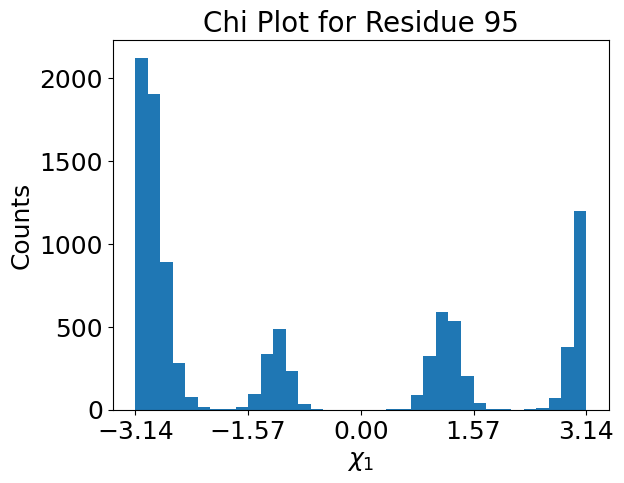

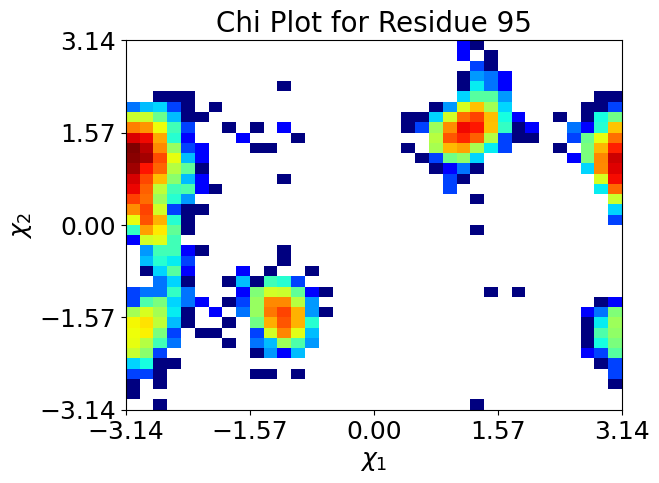

In [17]:

def plot_chi(res, title):
    if res in dihedral_dict['chi1']:
        plt.hist(dihedral_dict['chi1'][res], bins=36, range=[-3.14, 3.14])        
        plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14], fontsize=35)
        plt.xlabel('$\chi_1$', size=18)
        plt.ylabel('Counts', size=18)
        plt.tick_params(labelsize=18)
        plt.title(title, size=20)
        plt.show()
        plt.clf()   
    if res in dihedral_dict['chi2']:
        plt.hist2d(dihedral_dict['chi1'][res], dihedral_dict['chi2'][res], bins=36, range=[[-3.14, 3.14], [-3.14, 3.14]], norm=colors.LogNorm(), cmap='jet')
        plt.xlabel('$\chi_1$', size=18)
        plt.ylabel('$\chi_2$', size=18)
        plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14], fontsize=35)
        plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14], fontsize=35)
        plt.tick_params(labelsize=18)
        plt.title(title, size=20)
        plt.show()

def plot_multiple_chi(residues):
    for res in residues:
        title = f'Chi Plot for Residue {res}'
        plot_chi(res, title)

# Example usage
plot_multiple_chi([87, 88, 89, 90, 91, 92, 93, 94, 95])


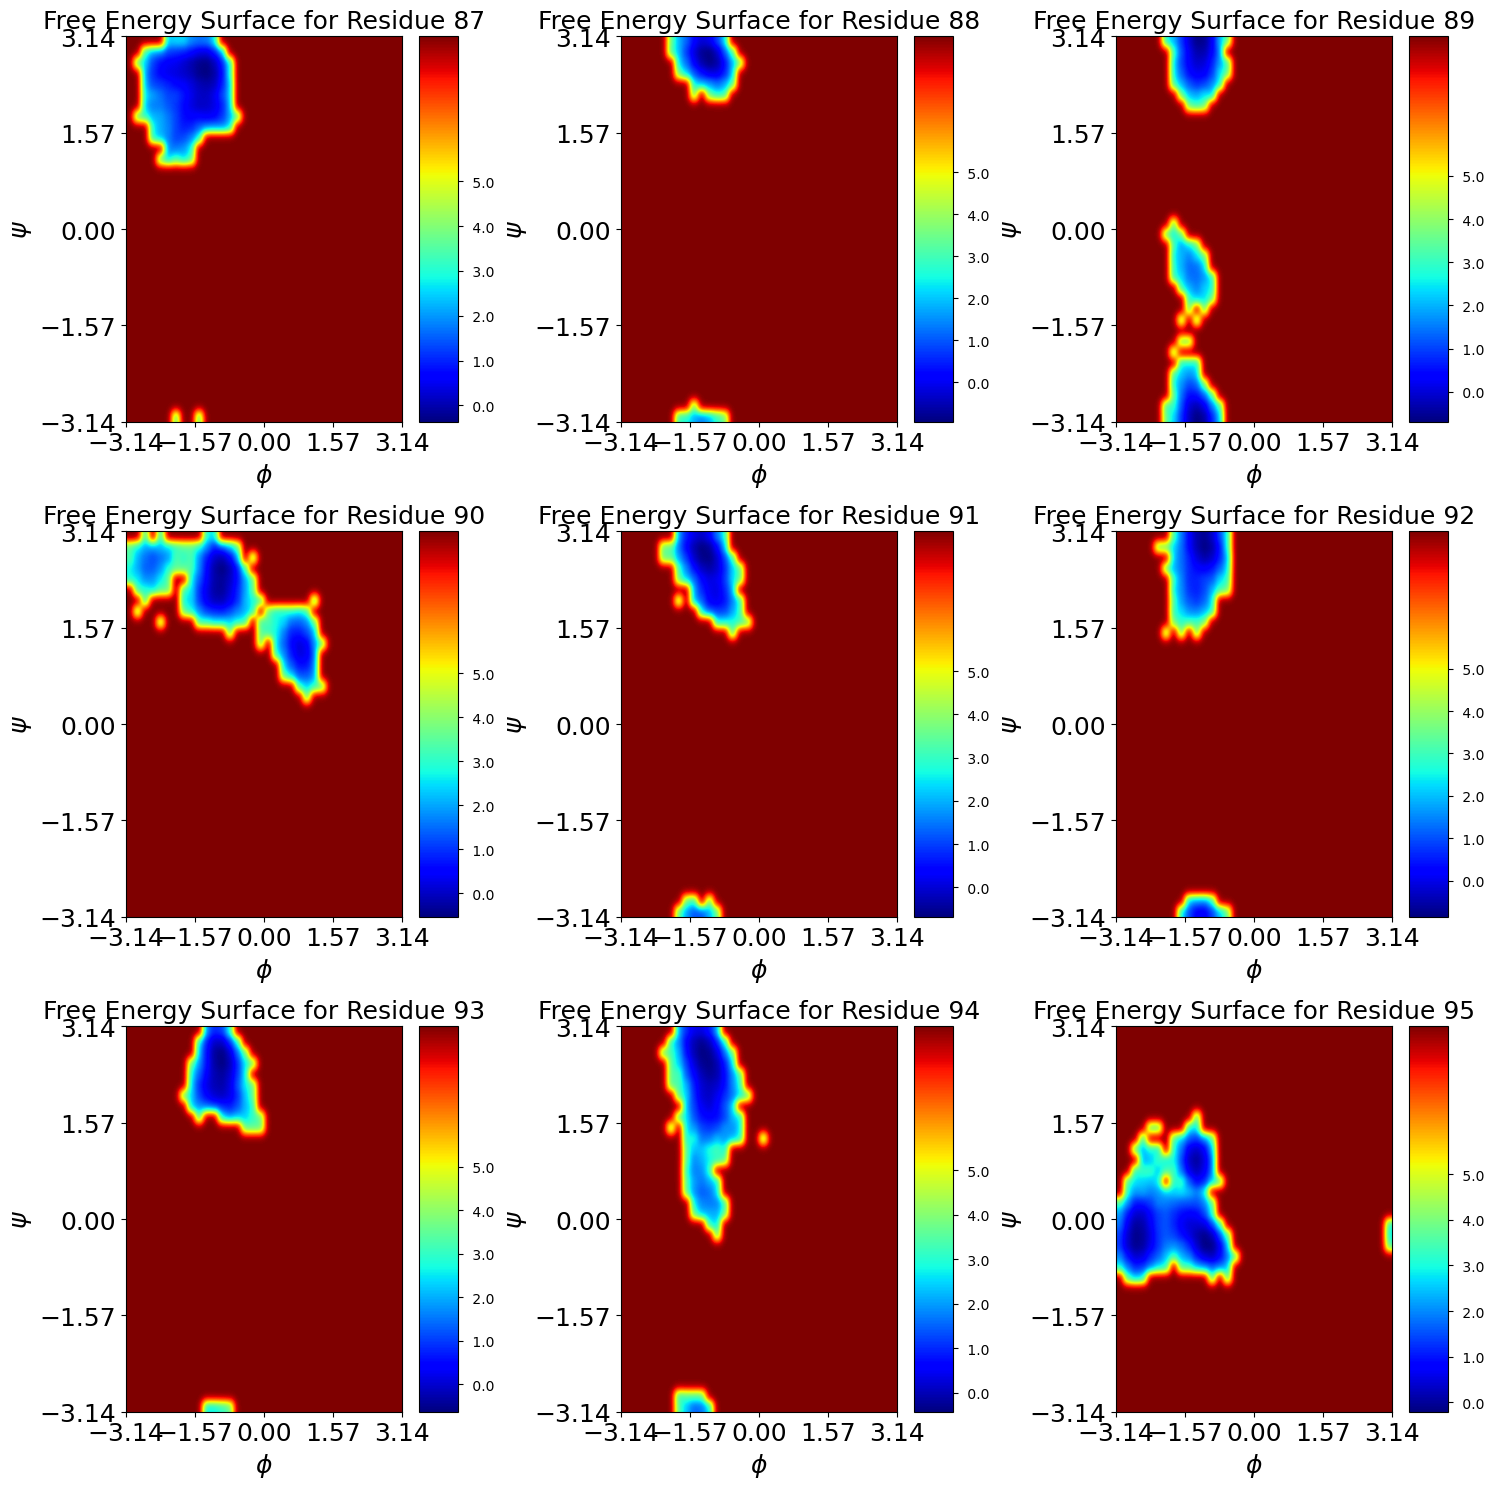

In [18]:
def plot_phipsi_FES(*residues):
    num_plots = len(residues)
    num_cols = 3  
    num_rows = (num_plots + num_cols - 1) // num_cols  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    for i, res in enumerate(residues):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        
        free_energy, xedges, yedges = np.histogram2d(dihedral_dict['psi'][res], dihedral_dict['phi'][res], 36, [[-3.14, 3.14], [-3.14, 3.14]], density=True, weights=None)
        free_energy = np.log(np.flipud(free_energy) + 0.000001)
        T = 300
        kbT = T * 0.008314 / 4.184  # kT in kcal/mol
        dG = -(kbT) * free_energy  # Convert to kcal/mol
        im = ax.imshow(dG, interpolation='gaussian', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
        cbar_ticks = [0, 1, 2, 3, 4, 5]
        cb = plt.colorbar(im, ax=ax, ticks=cbar_ticks, format='% .1f', aspect=10)  # grab the Colorbar instance
        ax.set_xlabel('$\phi$', size=18)
        ax.set_ylabel('$\psi$', size=18)
        ax.tick_params(labelsize=18)
        ax.set_title(f'Free Energy Surface for Residue {res}', size=18)
        ax.set_xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
        ax.set_yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])

    plt.tight_layout()
    plt.show()

plot_phipsi_FES(87, 88, 89, 90, 91, 92, 93, 94, 95)


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 [Text(0, -0.1, '−0.1'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.20000000000000004, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5000000000000001, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7')])

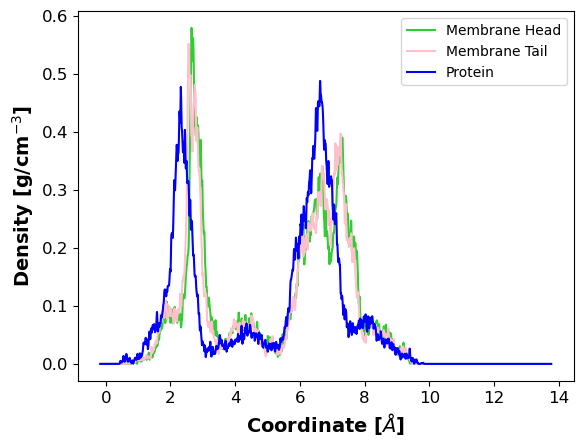

In [19]:
#Compute density profiles for the subdivided parts of the sytem considering the vector normal to the membrane bilayer (Z axis)**

import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import os

# Load trajectory using mdtraj
#traj_load = md.load("stripped_trajectory_001.xtc", top="stripped_structure_frame1.pdb")
traj_load = md.load(trajectory, top=pdb)

# Define atom selections for different components
polar_density = "name O"  # Example: Oxygen atoms for membrane head
apolar_density = "name C"  # Example: Carbon atoms for membrane tail
protein_density = "protein"  # Example: All atoms in the protein

# Compute density profiles using mdtraj
density, bin_edges = np.histogram(traj_load.xyz[:, :, 2], bins='auto', density=True)

head_density, _ = np.histogram(traj_load.atom_slice(traj_load.top.select(polar_density)).xyz[:, 2], bins=bin_edges, density=True)
tail_density, _ = np.histogram(traj_load.atom_slice(traj_load.top.select(apolar_density)).xyz[:, 2], bins=bin_edges, density=True)
prot_density, _ = np.histogram(traj_load.atom_slice(traj_load.top.select(protein_density)).xyz[:, 2], bins=bin_edges, density=True)

# Smooth density profiles using Gaussian filter
head_s = gaussian_filter1d(head_density, sigma=2)
tail_s = gaussian_filter1d(tail_density, sigma=2)
prot_s = gaussian_filter1d(prot_density, sigma=2)

# Plot density profiles
plt.plot(bin_edges[:-1], head_s, alpha=1, color='limegreen', linewidth=1.5, label='Membrane Head')
plt.plot(bin_edges[:-1], tail_s, alpha=1, color='pink', linewidth=1.5, label='Membrane Tail')
plt.plot(bin_edges[:-1], prot_s, alpha=1, color='blue', linewidth=1.5, label='Protein')

# Add legend and labels
plt.legend()
plt.xlabel("Coordinate [$\AA$]", fontsize=14, fontweight='bold')
plt.ylabel("Density [g/cm$^{-3}$]", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot
#workDir = "your_directory"
#Output_name = "density_profiles"
#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')
#plt.show()


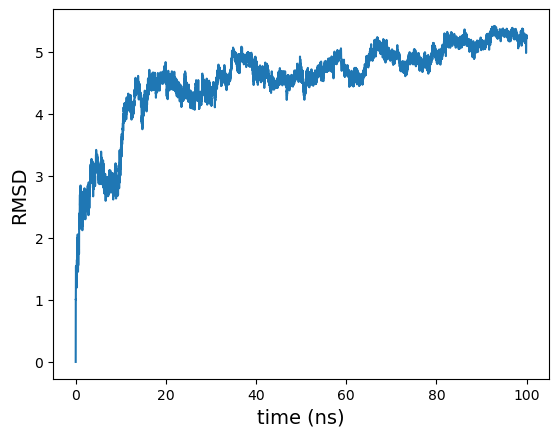

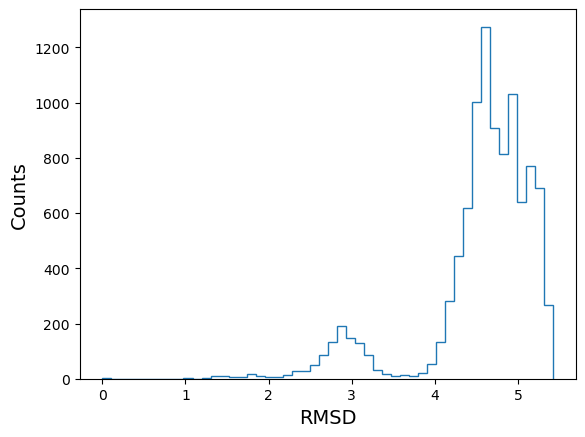

In [32]:
#Calculate the RMSD of the whole structure and make a histogram from the starting structure 
time=np.linspace(0,100,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

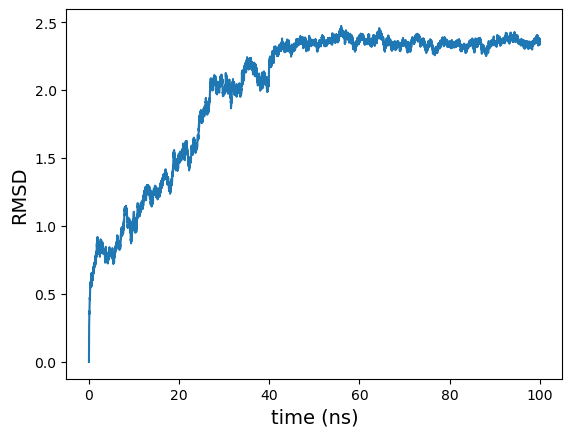

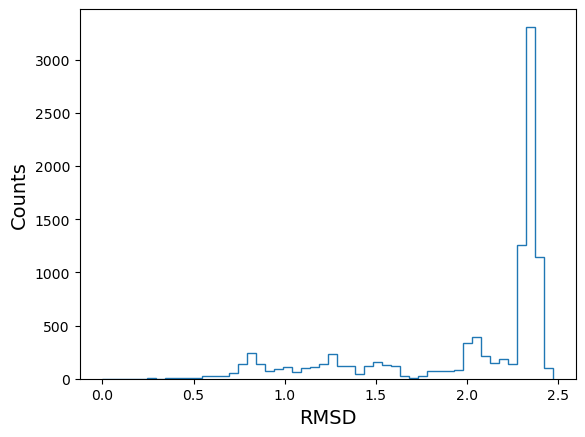

In [28]:
#Calculate the RMSD and make a histogram from the starting structure 
time=np.linspace(0,100,trj.n_frames)
trj_p = trj.atom_slice(trj.topology.select("protein"))
# rmsd = md.rmsd(trj, trj, 0)
rmsd = md.rmsd(trj_p, trj_p, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

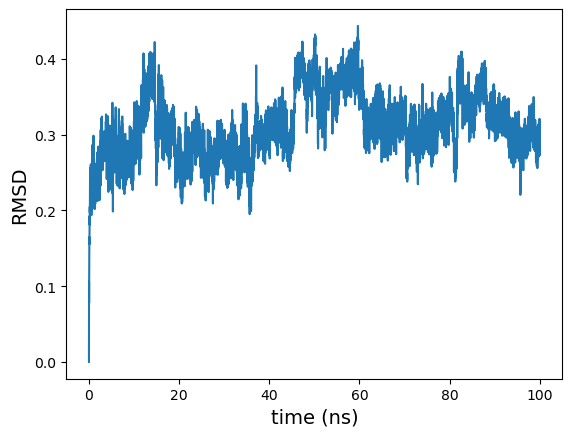

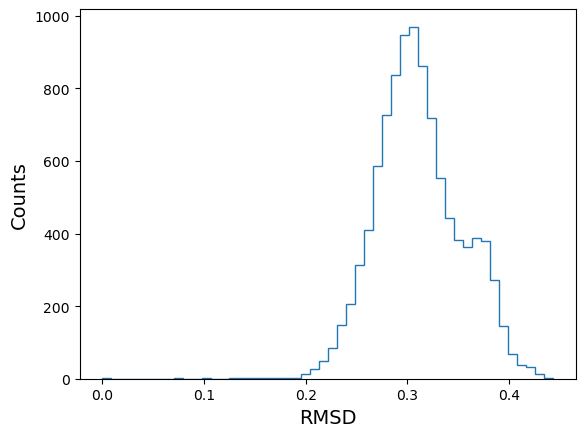

In [34]:
#Lets Calculate the RMSD and make a histogram from the starting structure 
time=np.linspace(0,100,trj.n_frames)
trj_pro = trj.atom_slice(trj.topology.select("resid 87 to 95"))
# rmsd = md.rmsd(trj, trj, 0)
rmsd = md.rmsd(trj_pro, trj_pro, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

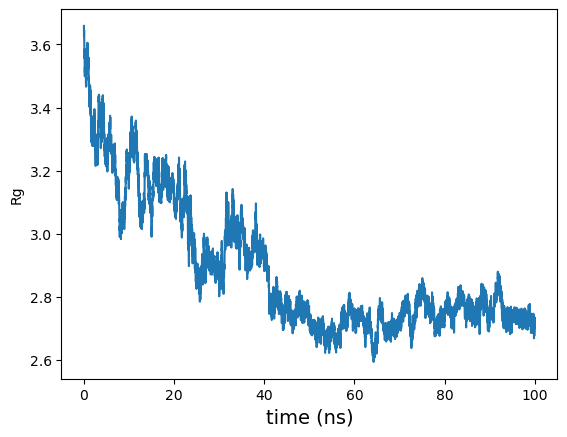

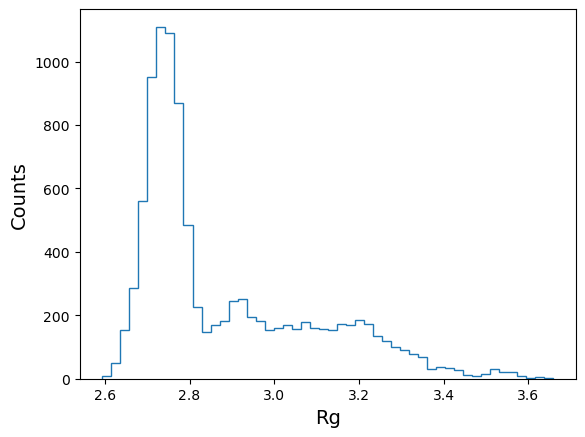

In [39]:
#Lets calculate the radius of gyration of the protein and make a histogram
rg=md.compute_rg(trj_p, masses=None)
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

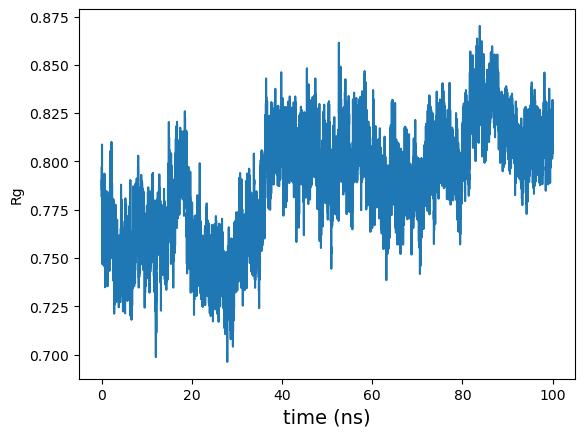

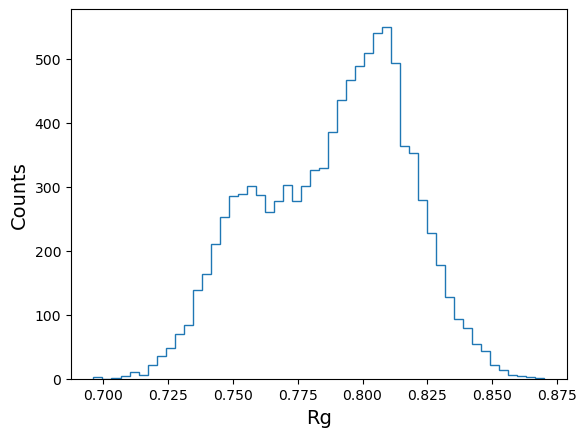

In [38]:
#Lets calculate the radius of gyration of the proline rich motif and make a histogram
rg=md.compute_rg(trj_pro, masses=None)
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

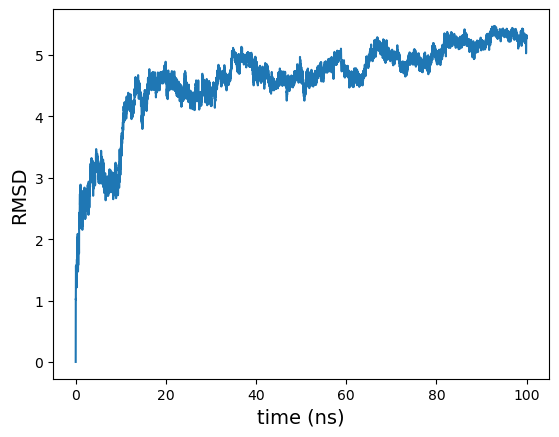

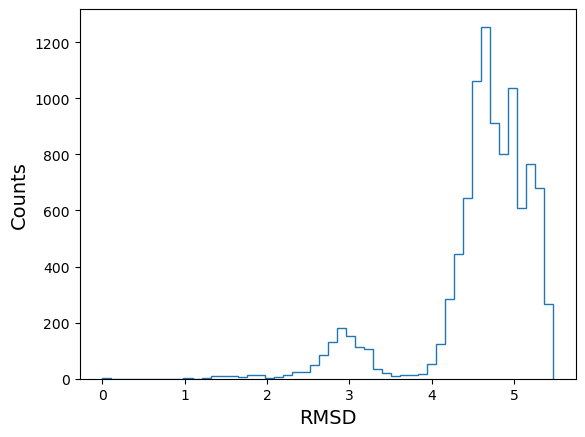

In [35]:
#Lets Calculate the RMSD for the membrane and make a histogram from the starting structure 
time=np.linspace(0,100,trj.n_frames)
trj_m = trj.atom_slice(trj.topology.select("not protein"))
# rmsd = md.rmsd(trj, trj, 0)
rmsd = md.rmsd(trj_m, trj_m, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

In [96]:
#Lets identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))
    

ARG3-NE -- POP374-O13
ARG3-NE -- POP374-O14
ARG3-NH1 -- POP354-O13
ARG3-NH2 -- POP374-O13
ARG3-NH2 -- POP354-O13
GLU4-N -- MET1-O
GLU4-N -- GLU4-OE1
GLU4-N -- GLU4-OE2
ILE5-N -- MET1-O
ILE5-N -- ILE2-O
SER6-N -- ILE2-O
ASN7-N -- ARG3-O
ASN7-N -- GLU4-O
ASN7-ND2 -- GLU4-OE1
ASN7-ND2 -- GLU4-OE2
LEU8-N -- GLU4-O
LEU8-N -- ILE5-O
GLN9-N -- ILE5-O
LYS10-N -- SER6-O
LYS10-N -- ASN7-O
ASP11-N -- ASN7-O
ASP11-N -- LEU8-O
ILE12-N -- LEU8-O
ILE12-N -- GLN9-O
ILE13-N -- GLN9-O
ASN14-N -- LYS10-O
ASN14-N -- ASP11-O
ILE15-N -- ASP11-O
ILE15-N -- ILE12-O
GLN16-N -- ILE12-O
GLN16-NE2 -- MET35-O
GLN16-NE2 -- PHE37-O
ASP17-N -- ILE13-O
ASP17-N -- ASN14-O
SER18-N -- ASN14-O
SER18-N -- ILE15-O
TYR19-N -- ILE15-O
TYR19-N -- GLN16-O
SER20-N -- GLN16-O
SER20-N -- ASP17-O
ASN21-N -- ASP17-O
ASN21-N -- SER18-O
ASN21-ND2 -- ASP17-O
ASN22-N -- SER18-O
ASN22-N -- TYR19-O
VAL24-N -- ASN22-OD1
ASP26-N -- ASN30-OD1
GLY28-N -- ASP26-OD1
GLY28-N -- ASP26-OD2
ARG29-N -- GLU47-OE1
ARG29-N -- GLU47-OE2
ARG29-NE -- ASN3

In [97]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[   53    54 52108] ARG3-NE POP374-O13
[   53    54 52109] ARG3-NE POP374-O14
[   55    57 49428] ARG3-NH1 POP354-O13
[   58    59 52108] ARG3-NH2 POP374-O13
[   58    60 49428] ARG3-NH2 POP354-O13
[62 63 10] GLU4-N MET1-O
[62 63 75] GLU4-N GLU4-OE1
[62 63 76] GLU4-N GLU4-OE2
[77 78 10] ILE5-N MET1-O
[77 78 26] ILE5-N ILE2-O
[96 97 26] SER6-N ILE2-O
[107 108  46] ASN7-N ARG3-O
[107 108  70] ASN7-N GLU4-O
[117 118  75] ASN7-ND2 GLU4-OE1
[117 118  76] ASN7-ND2 GLU4-OE2
[121 122  70] LEU8-N GLU4-O
[121 122  84] LEU8-N ILE5-O
[140 141  84] GLN9-N ILE5-O
[157 158 104] LYS10-N SER6-O
[157 158 115] LYS10-N ASN7-O
[179 180 115] ASP11-N ASN7-O
[179 180 129] ASP11-N LEU8-O
[191 192 129] ILE12-N LEU8-O
[191 192 148] ILE12-N GLN9-O
[210 211 148] ILE13-N GLN9-O
[229 230 165] ASN14-N LYS10-O
[229 230 187] ASN14-N ASP11-O
[243 244 187] ILE15-N ASP11-O
[243 244 198] ILE15-N ILE12-O
[262 263 198] GLN16-N ILE12-O
[275 276 574] GLN16-NE2 MET35-O
[275 277 602] GLN16-NE2 PHE37-O
[279 280 217] ASP17-N ILE13

[1567 1568 1540] MET96-N PRO94-O


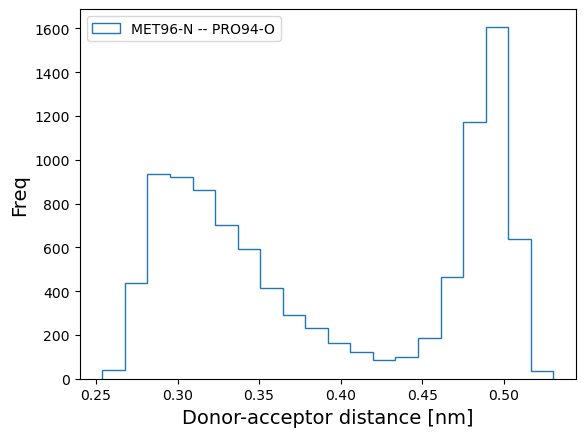

In [101]:
Hbond_index=168
hbond=hbonds[Hbond_index]
donor = top.atom(hbond[0])
acc = top.atom(hbond[2])
print(hbond,donor,acc)

da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)
plt.hist(da_distance,histtype='step',bins=20, label=label(hbonds[Hbond_index]))
#for i in [2, 3, 4]:
#    plt.hist(da_distances[:, i], color=next(color),histtype='step',bins=10, label=label(hbonds[i]), alpha=0.5)
plt.legend()
plt.ylabel('Freq',size=14);
plt.xlabel('Donor-acceptor distance [nm]',size=14)
plt.show()

[1584 1585 1540] LEU97-N PRO94-O


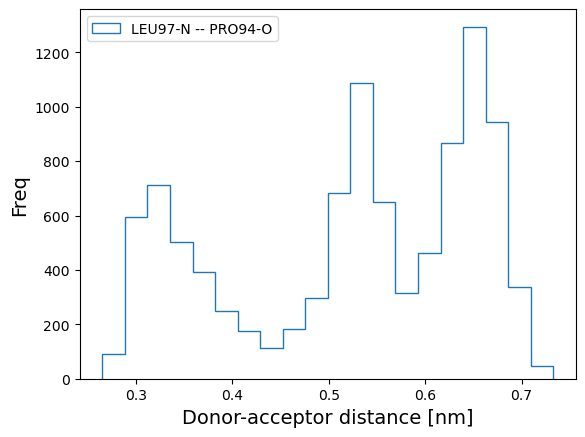

In [100]:
Hbond_index=169
hbond=hbonds[Hbond_index]
donor = top.atom(hbond[0])
acc = top.atom(hbond[2])
print(hbond,donor,acc)

da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)
plt.hist(da_distance,histtype='step',bins=20, label=label(hbonds[Hbond_index]))
#for i in [2, 3, 4]:
#    plt.hist(da_distances[:, i], color=next(color),histtype='step',bins=10, label=label(hbonds[i]), alpha=0.5)
plt.legend()
plt.ylabel('Freq',size=14);
plt.xlabel('Donor-acceptor distance [nm]',size=14)
plt.show()

In [102]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []
for i in range(1, 130):
    contact_map = []
    contact_distance = []
    for j in range(1, 130):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


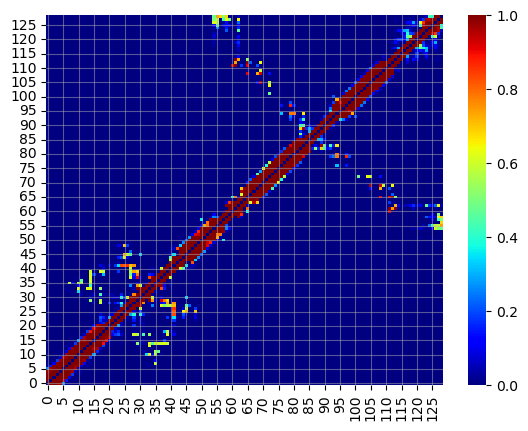

In [103]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)


In [105]:
#4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 

def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(phi,psi):
    cmean1=circular_mean(phi)
    cmean2=circular_mean(psi)
    numerator=(np.sum(np.sin(phi-cmean1)*np.sin(psi-cmean2)))
    denom=((np.sum(np.sin(phi-cmean1)**2)*np.sum(np.sin(psi-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [107]:
# Make correlation contact map
correlation_maps = []
for i in range(2, 130):
    cor_map = []
    for j in range(2, 130):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_cor_map)

(128, 128)

In [108]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:129]
#Lets Zero Out some of the Labels 
n=5
for i in range (0,128): 
  if (i % n !=0):
   seq_trunc[i]=''

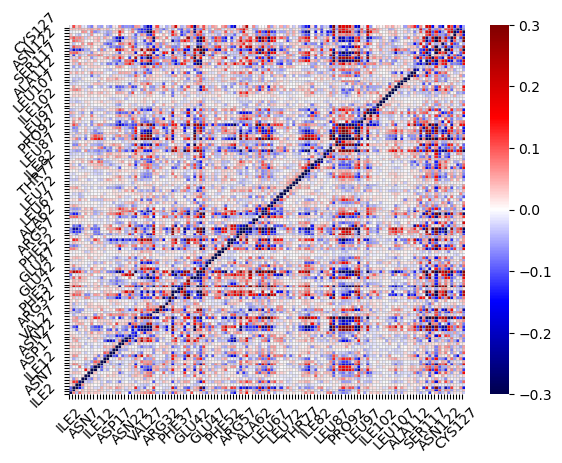

In [109]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.3, vmax=0.3,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,128))
ax.set_yticks(range(0,128))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

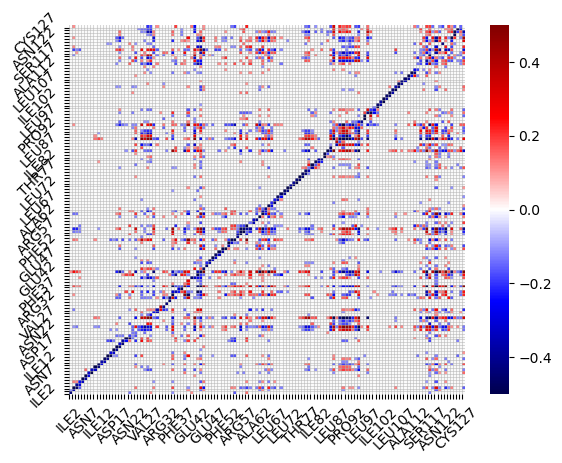

In [110]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,128))
ax.set_yticks(range(0,128))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

In [26]:
trj.topology.select("resname POPC")

array([], dtype=float64)

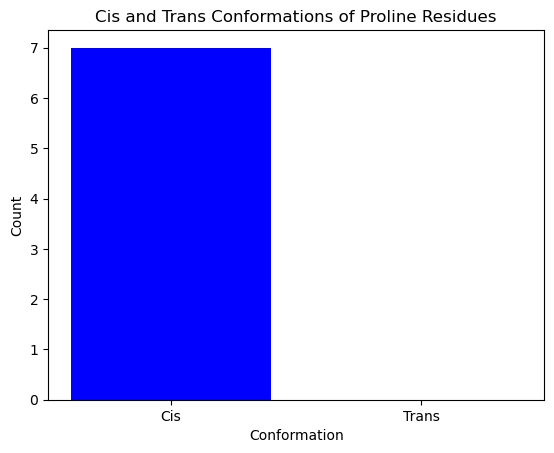

Cis conformation count: 7, Percentage: 100.0%
Trans conformation count: 0, Percentage: 0.0%


In [33]:
#calculate the percentage of prolines in cis or trans conformers in the proline rich motif

# Load trajectory file and topology

# Select proline residues in the proline-rich motif
# proline_indices = traj.topology.select("resname PRO")
trj_pro = trj.atom_slice(trj.topology.select("resid 87 to 95"))

# Compute omega dihedral angles for each proline residue
omega_angles = md.compute_omega(trj_pro)

# Initialize counters for cis and trans conformations
cis_count = 0
trans_count = 0

# Loop over frames in the trajectory
for frame_angles in omega_angles:
    trans_count += np.sum(frame_angles < -90)
    cis_count += np.sum(frame_angles > 90)

# Compute percentages
total_count = cis_count + trans_count
cis_percentage = (cis_count / total_count) * 100
trans_percentage = (trans_count / total_count) * 100

# Create a bar plot


labels = ['Cis', 'Trans']
counts = [cis_count, trans_count]

plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Conformation')
plt.ylabel('Count')
plt.title('Cis and Trans Conformations of Proline Residues')
plt.show()

# Output results
print(f"Cis conformation count: {cis_count}, Percentage: {cis_percentage}%")
print(f"Trans conformation count: {trans_count}, Percentage: {trans_percentage}%")


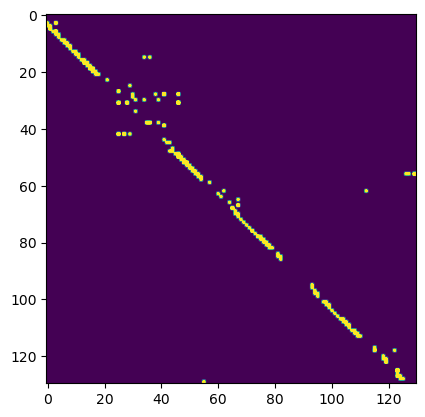

In [59]:
plt.imshow(hbond_populations_protein, vmax=1)

In [77]:
trj = md.load(trajectory, top=pdb)
print("Shape of trj.xyz:", trj.xyz.shape)


Shape of trj.xyz: (10000, 68302, 3)


In [79]:
# Align trajectory to the first frame (reference frame)
traj_align = md.rmsd(trj, trj, frame=0, atom_indices=mask_protein)

# Print the shape of traj_align to debug the issue
print("Shape of traj_align:", traj_align.shape)


Shape of traj_align: (10000,)


In [81]:
print("Number of atoms to align:", num_atoms)
print("Shape of traj_align:", traj_align.shape)


Number of atoms to align: 140
Shape of traj_align: (10000,)


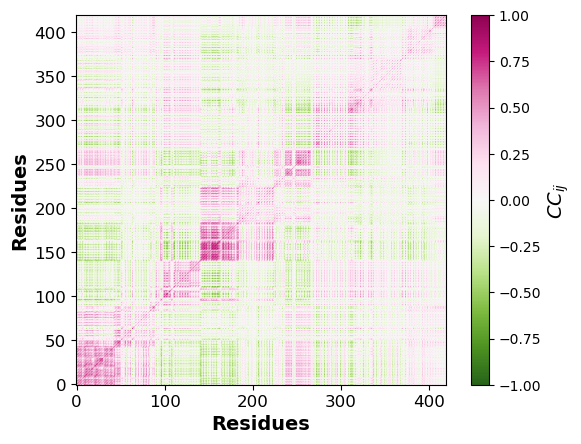

In [84]:
# Align trajectory to the first frame (reference frame) using the specified atom indices
traj_align = trj.superpose(trj, frame=0, atom_indices=atom_indices_to_align)

# Compute cross-correlation matrix for aligned residues
num_frames = traj_align.n_frames
num_atoms = len(atom_indices_to_align)

# Extract coordinates for aligned atoms
aligned_coordinates = traj_align.xyz[:, atom_indices_to_align, :]

# Reshape the aligned coordinates into a 2-dimensional array
traj_reshaped = aligned_coordinates.reshape(num_frames, -1)

# Compute cross-correlation matrix
mat_cc = np.corrcoef(traj_reshaped.T)

# Plot the cross-correlation matrix
plt.imshow(mat_cc, cmap='PiYG_r', interpolation='bicubic', vmin=-1, vmax=1, origin='lower')
plt.xlabel('Residues', fontsize=14, fontweight='bold')
plt.ylabel('Residues', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_{ij}$', fontsize=14, fontweight='bold')
plt.show()


In [40]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj_pro.superpose(trj_pro, 0)
reduced_cartesian = pca1.fit_transform(trj_pro.xyz.reshape(trj_pro.n_frames, trj_pro.n_atoms * 3))
print(reduced_cartesian.shape)

(10000, 2)


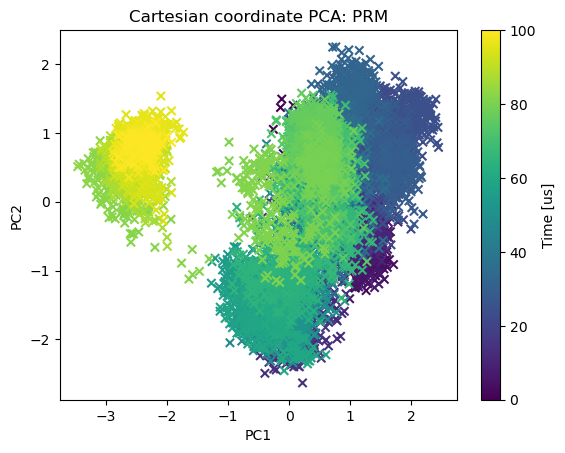

In [41]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: PRM')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

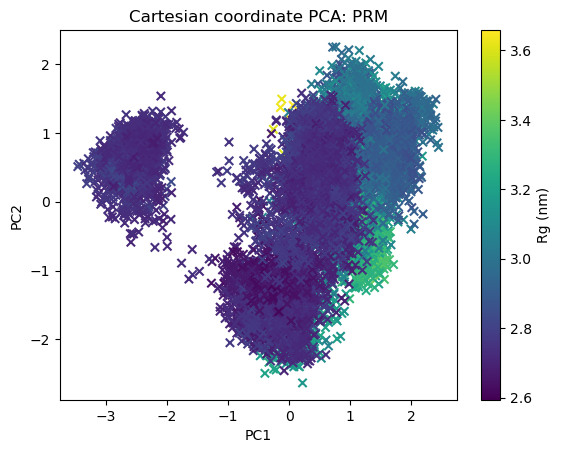

In [42]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: PRM')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

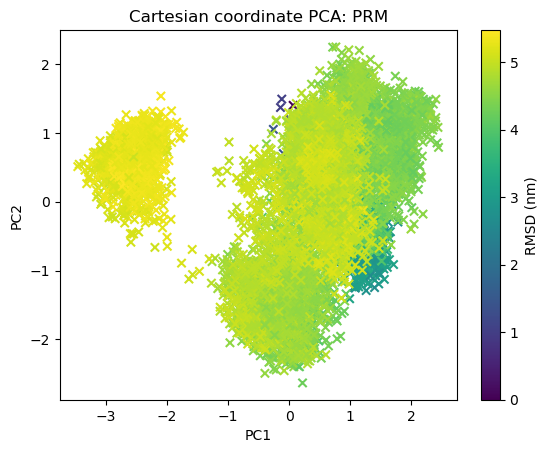

In [43]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: PRM')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

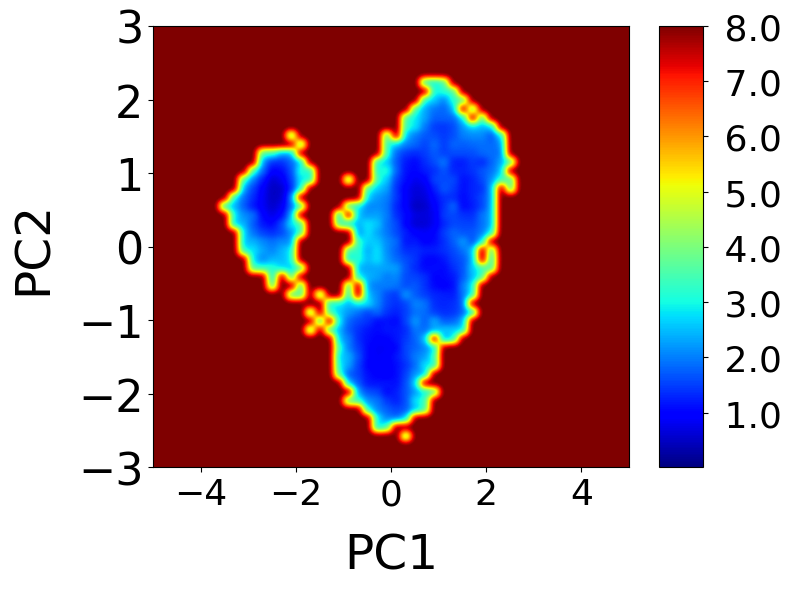

In [40]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 50, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -3, 3, -5, 5)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-5,5)
plt.ylim(-3,3)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [41]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters



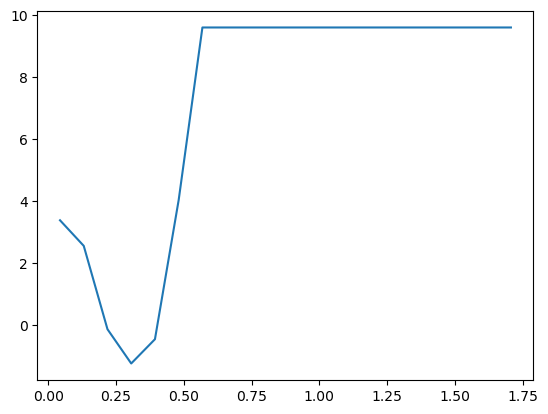

In [42]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)

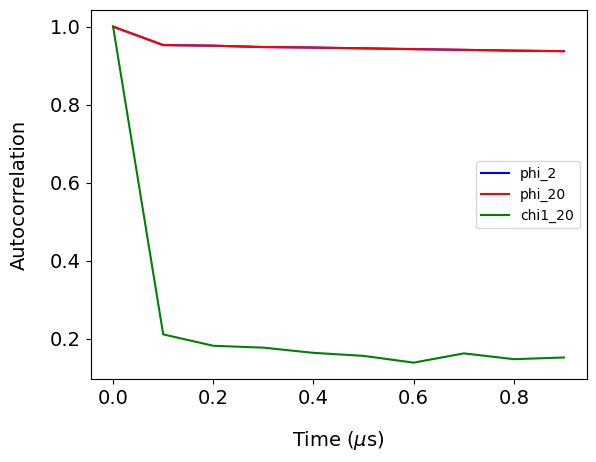

In [89]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['phi'][90],lags)
phi20_acf=autocorr1(dihedral_dict['phi'][90],lags)
chi20_acf=autocorr1(dihedral_dict['chi1'][90],lags)

plt.plot(time[lags],phi2_acf,color='b',label='phi_90')
plt.plot(time[lags],phi20_acf,color='r',label='phi_90')
plt.plot(time[lags],chi20_acf,color='g',label='chi1_90')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

In [30]:
#Possible Homework Prompt:
#Visualize the lowest free energy basin
basin_frames=np.where((rmsd>0.60) & (rmsd<0.80))[0]
len(basin_frames)
trj[basin_frames].save_dcd(outdir+'rmsd.dgmin.basin.dcd')

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

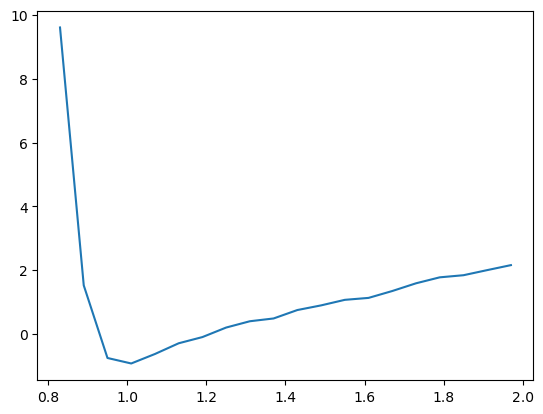

In [31]:
dG_rg,xedges=free_energy1D(rg,300,0.8,2.0,20)

plt.plot(xedges,dG_rg)

c:\Users\hainn\anaconda3\envs\CHEM101\Lib\site-packages\numpy\lib\histograms.py:1067: RuntimeWarning: invalid value encountered in divide
  hist /= s


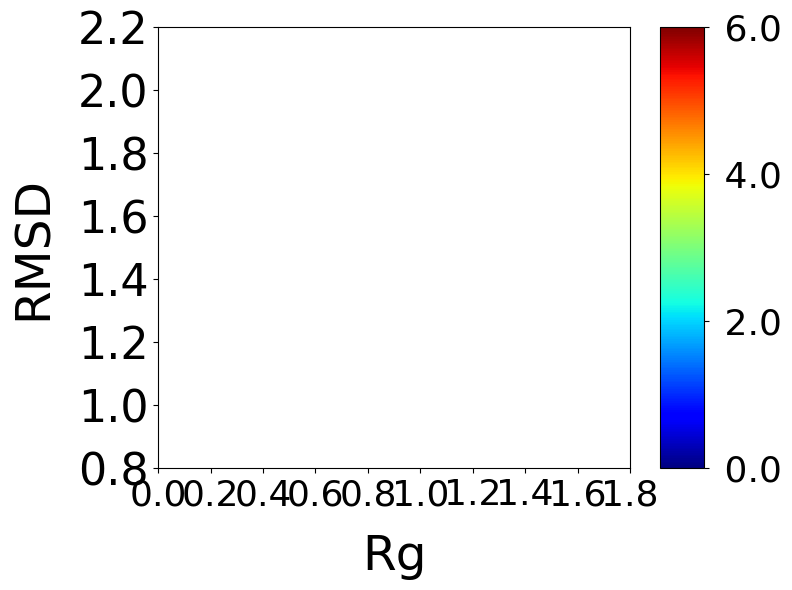

In [43]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.2, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()